<a href="https://colab.research.google.com/github/moimigueldev/tensorflow-ztm/blob/main/cats_dogs/cats_dogs_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify dogs and cats with Binary CNN
[Original Kaggle Notebook](https://www.kaggle.com/datasets/tongpython/cat-and-dog)

# Import Data and helpers

In [ ]:
import os
list_dir = os.listdir('.')

if 'cat_dog.zip?dl=0' not in list_dir:
  # import dataset
  !wget https://www.dropbox.com/s/qpul0hnbovcnmmb/cat_dog.zip?dl=0

  # import helpers
  !wget !wget !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
from helper_functions import plot_loss_curves, walk_through_dir, compare_historys, unzip_data

In [ ]:
list_dir = os.listdir('.')
if 'images' not in list_dir:
  unzip_data('cat_dog.zip?dl=0')


In [ ]:
walk_through_dir('images/train_10_percent')

There are 2 directories and 0 images in 'images/train_10_percent'.
There are 0 directories and 400 images in 'images/train_10_percent/cats'.
There are 0 directories and 400 images in 'images/train_10_percent/dogs'.


# Preprocess Data

In [ ]:
data_augmentation_dial = 0.2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create dat augmentation stage wsith horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip('horizontal'),
                                      preprocessing.RandomRotation(data_augmentation_dial),
                                      preprocessing.RandomZoom(data_augmentation_dial),
                                      preprocessing.RandomHeight(data_augmentation_dial),
                                      preprocessing.RandomWidth(data_augmentation_dial),
                                      
                                      # Keep for models like ResNet50v2 but efficientNet's 
                                      # having resclaing built in means we don't need it for this model
                                      # preprocessing.Rescale(1./255)
], name='data_augmentation')

In [ ]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'images/test',
    label_mode='binary',
    image_size=(224, 224),
)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'images/train',
    label_mode='binary',
    image_size=(224, 224),
)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    'images/train_10_percent',
    label_mode='binary',
    image_size=(224, 224),
)

Found 2022 files belonging to 2 classes.
Found 8000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


# Create base model

In [ ]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape, name='input_layer')

# If using a model like ResNet50v2 you will need to normalize inputs (you don't have to if you're using efficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)



# Create Checkpoint callback

In [ ]:
checkpoint_path = 'efficientNetB0/checkpoint.ckpt'
initial_epochs = 5

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=False,
    # save_freq="epoch"
    period=initial_epochs,
    verbose=1
)

# EfficientNetB0

## Model 1: Feature Extraction


In [ ]:
model_1 = keras.Model(inputs, outputs)

model_1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])


history_1 = model_1.fit(
    train_data_10_percent,
    epochs=initial_epochs,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data)),
    callbacks=[checkpoint_callback]
)



Epoch 1/5
25/25 [==============================] - 10s 198ms/step - loss: 0.4889 - accuracy: 0.7887 - val_loss: 0.2534 - val_accuracy: 0.9355
Epoch 2/5
25/25 [==============================] - 3s 119ms/step - loss: 0.2418 - accuracy: 0.9375 - val_loss: 0.1560 - val_accuracy: 0.9688
Epoch 3/5
25/25 [==============================] - 3s 119ms/step - loss: 0.1780 - accuracy: 0.9463 - val_loss: 0.1132 - val_accuracy: 0.9805
Epoch 4/5
25/25 [==============================] - 3s 117ms/step - loss: 0.1537 - accuracy: 0.9563 - val_loss: 0.0963 - val_accuracy: 0.9785
Epoch 5/5
24/25 [===========================>..] - ETA: 0s - loss: 0.1250 - accuracy: 0.9661
Epoch 5: saving model to efficientNetB0/checkpoint.ckpt
INFO:tensorflow:Assets written to: efficientNetB0/checkpoint.ckpt/assets
25/25 [==============================] - 38s 2s/step - loss: 0.1241 - accuracy: 0.9663 - val_loss: 0.0985 - val_accuracy: 0.9805


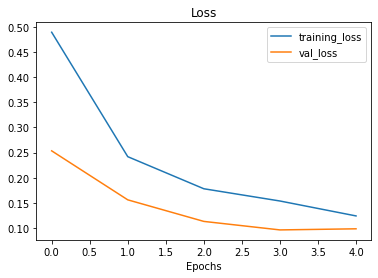

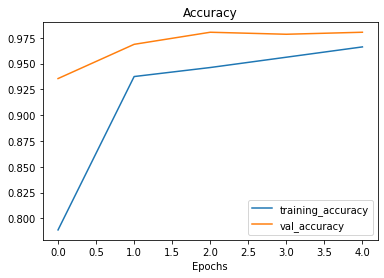

In [ ]:
plot_loss_curves(history_1)

In [ ]:
model_1_results = model_1.evaluate(test_data)

64/64 [==============================] - 4s 54ms/step - loss: 0.0909 - accuracy: 0.9797


## Model 2: Fine Tuning
EfficientNetB0 gives us great results right off the bat with data augmentation and with only 10% of the training data.

Now let's try to unfreeze 10% layers and train on our own custom data

In [ ]:
base_model.trainable = True

# Freeze all layers except the last 10%
for layer in base_model.layers[:- int(.10 * len(base_model.layers))]:
  layer.trainable = False

In [ ]:
# # Create new model and recompile & fit
model_2 = tf.keras.Model(inputs, outputs)
model_2.load_weights(checkpoint_path)
model_2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])
fine_tune_epochs = initial_epochs + 5
history_2 = model_2.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data)),
    initial_epoch=history_1.epoch[-1]
)
compare_historys(history_1, history_2)

Epoch 5/10
250/250 [==============================] - 27s 86ms/step - loss: 0.1239 - accuracy: 0.9532 - val_loss: 0.0351 - val_accuracy: 0.9883
Epoch 6/10
171/250 [===================>..........] - ETA: 6s - loss: 0.0722 - accuracy: 0.9715

In [ ]:
model_2_results = model_2.evaluate(test_data)

**Summary:** EfficientNetB0 gave us a high accuracy score and the improvement from unfreezing layers is minimal.

# ResNet50V2

EfficientNetB0 proved to be usefull even before fine tuning, so let's try a different popular model to compare results

In [ ]:
# Create New Checkpoint
checkpoint_path = 'resNet50V2/checkpoint.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=False,
    period=initial_epochs,
    verbose=1
)

In [ ]:
# Create base model
input_shape = (224, 224, 3)

resNet_model = tf.keras.applications.ResNet50V2(include_top=False)
resNet_model.trainable = False

inputs = tf.keras.Input(shape=input_shape, name='input_layer')


x = data_augmentation(inputs)

x = resNet_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)



## Model 3

In [ ]:
# Compile & Fit the model

model_3 = tf.keras.Model(inputs, outputs)
model_3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01), metrics='accuracy')
history_3 = model_3.fit(
  train_data_10_percent,
  epochs = initial_epochs,
  steps_per_epoch=len(train_data_10_percent),
  validation_data=test_data,
  validation_steps=int(.25 * len(test_data)),
  callbacks=[checkpoint_callback]
)
plot_loss_curves(history_3)

In [ ]:
model_3_results = model_3.evaluate(test_data)

Not very good results with ResNet50V2

Let's try unfreezing some layers and training on full test dataset to see if model improves

Let's try unlocking the last 10% of base layers

In [ ]:
resNet_model.trainable = True

# Freeze all layers except the last 10%
for layer in resNet_model.layers[:- int(.10 * len(resNet_model.layers))]:
  layer.trainable = False



##Model 4

In [ ]:
# # Create new model and recompile & fit
model_4 = tf.keras.Model(inputs, outputs)
model_4.load_weights(checkpoint_path)
model_4.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])
fine_tune_epochs = initial_epochs + 5
history_4 = model_4.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data)),
    initial_epoch=history_3.epoch[-1]
)
compare_historys(history_3, history_4)




In [ ]:
model_4_results = model_4.evaluate(test_data)

Summary: ResNet50V2 did not perform nearly as well as efficientNetB0. Let's try one more model 

# Xception

In [ ]:
# Create New Checkpoint
checkpoint_path = 'xception/checkpoint.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=False,
    period=initial_epochs,
    verbose=1
)

In [ ]:
# Create base model
input_shape = (224, 224, 3)

xception_model = tf.keras.applications.Xception(include_top=False)
xception_model.trainable = False

inputs = tf.keras.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs)

x = xception_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)



## Model 5

In [ ]:
# Compile & Fit the model

model_5 = tf.keras.Model(inputs, outputs)
model_5.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')
history_5 = model_5.fit(
  train_data_10_percent,
  epochs = initial_epochs,
  steps_per_epoch=len(train_data_10_percent),
  validation_data=test_data,
  validation_steps=int(.25 * len(test_data)),
  callbacks=[checkpoint_callback]
)
plot_loss_curves(history_5)

In [ ]:
model_5_results = model_5.evaluate(test_data)

## Model 6

In [ ]:
xception_model.trainable = True

# Freeze all layers except the last 30%
for layer in xception_model.layers[:- int(.30 * len(xception_model.layers))]:
  layer.trainable = False



In [ ]:
# # Create new model and recompile & fit
model_6 = tf.keras.Model(inputs, outputs)
model_6.load_weights(checkpoint_path)
model_6.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])
fine_tune_epochs = initial_epochs + 5
history_6 = model_6.fit(
    train_data,
    epochs=fine_tune_epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(.25 * len(test_data)),
    initial_epoch=history_5.epoch[-1]
)
compare_historys(history_5, history_6)




In [ ]:
model_6_results = model_6.evaluate(test_data)

`Exception` gave us horrible results when unfreezing layers to train on custom data_augmentation
Just to make sure let's create a new xception model and evaluate the data without fitting to see if we could have gotten a better score


## Model 7


In [ ]:
# Create base model
input_shape = (224, 224, 3)

xception_model = tf.keras.applications.Xception(include_top=False)
xception_model.trainable = False

inputs = tf.keras.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs)

x = xception_model(x, training=False)

x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = layers.Dense(1, activation='sigmoid', name='output_layer')(x)



In [ ]:
# Compile & Fit the model

model_7 = tf.keras.Model(inputs, outputs)
model_7.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_7_results = model_7.evaluate(test_data)


In [ ]:
model_7_results[1], model_6_results[1]

Summary: When comparing `model_6` which is trained on custom data and `model_7` which is not trained on custom data, we see that they both perform the same at `~0.5` accuracy

 # Comparing models 

In [ ]:
import pandas as pd
models = [
          model_1_results,
          model_2_results,
          model_3_results,
          model_4_results,
          model_5_results,
          model_6_results,
          model_7_results,
]


results = pd.DataFrame(models, columns=['loss', 'accuracy'])
results

In [ ]:
# model_1_results.append('efficientNetB0')
